In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

# Generate Dataset

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

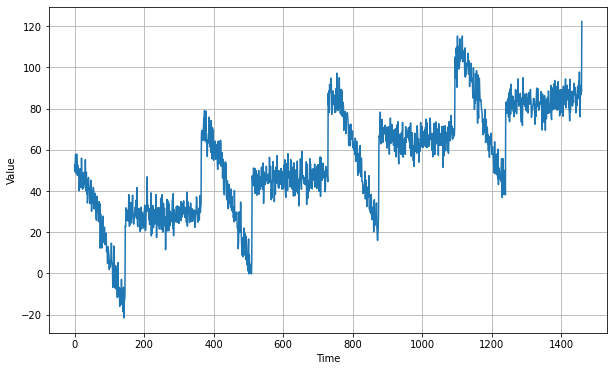

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) +\
         seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [30]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  


def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# generate samples for stateful traininig
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [33]:
sequential_window_dataset(x_train[:split_time], 30)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

# define model forcast function

In [56]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## split into train, val

In [101]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
x_train

In [ ]:
iter(seq2seq_window_dataset(series, 30)).next()

#Baseline Models

## Native Prediction using previous step

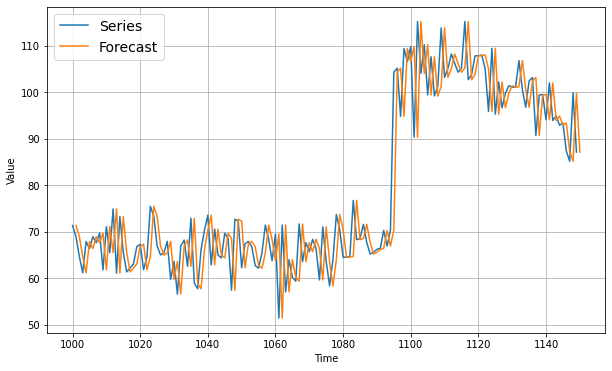

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [ ]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

## Moving Average Prediction

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

7.142418570620786

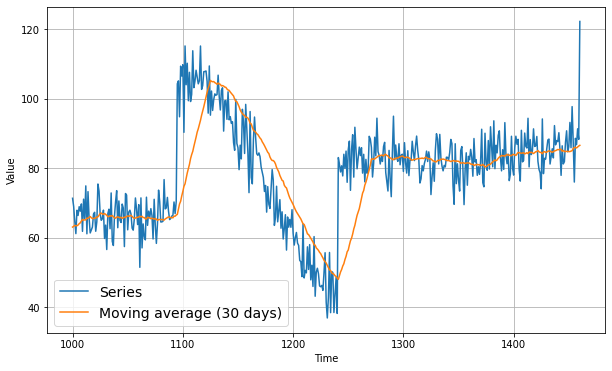

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

## Moving Avg wo Seasonality and Trend

5.839310562995895

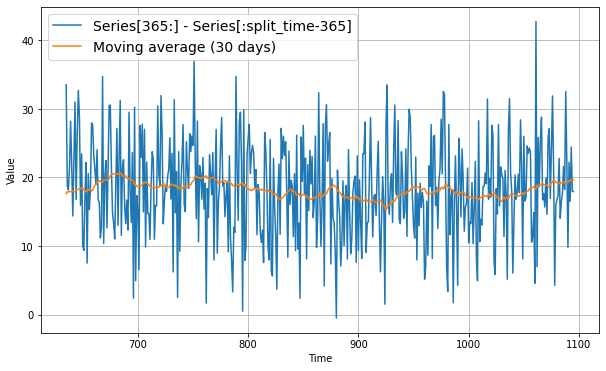

In [ ]:
diff_series = series[365:] - series[:-365] # shape (1096)
diff_t = time[:-365]

time_train = diff_t[:split_time-365]
x_train = diff_series[:split_time-365]
time_valid = diff_t[split_time-365:]
x_valid = diff_series[split_time-365:]

moving_avg = moving_average_forecast(diff_series, 50)[split_time-365-50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series[365:] - Series[:split_time-365]")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

5.8393105629958955

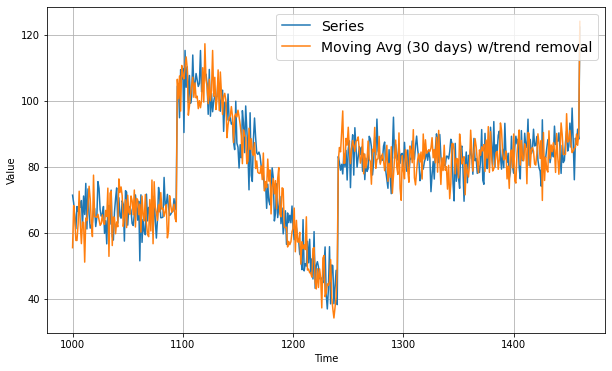

In [ ]:
# adding back trend and seasonality
moving_avg_ = series[split_time-365:-365] + moving_avg

plt.figure(figsize=(10,6))
plot_series(time[split_time:], series[split_time:], label='Series')
plot_series(time[split_time:], moving_avg_, label='Moving Avg (30 days) w/trend removal')

keras.metrics.mean_absolute_error(series[split_time:], moving_avg_).numpy()

4.842697801398176

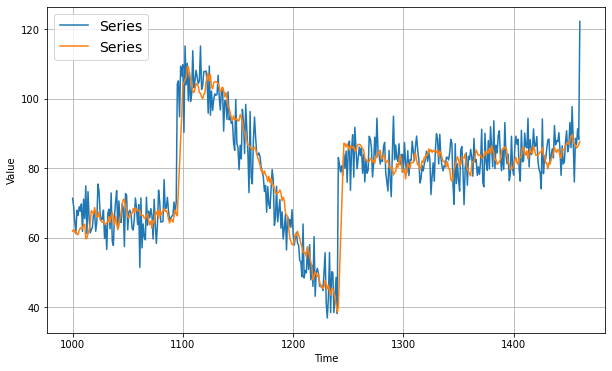

In [ ]:
# adding back trend and seasonality iwth smoothing
smooth_past = moving_average_forecast(series, 5)[split_time-365-5:-365] 
moving_avg_plus_smooth_past = moving_avg + smooth_past

plt.figure(figsize=(10,6))
plot_series(time[split_time:], series[split_time:], label='Series')
plot_series(time[split_time:], moving_avg_plus_smooth_past, label='Series')

keras.metrics.mean_absolute_error(series[split_time:], moving_avg_plus_smooth_past).numpy()

#NEURAL MODELS

## Custom Callback

### learning rate scheduler

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

### on epoch begine reset status

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

reset_states = ResetStatesCallback()

### early topping

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)

### save best checkpoint

In [89]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

## Preprocessing


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

##RNN Stateful

In [36]:
train_set = sequential_window_dataset(x_train[:split_time], 30)

In [35]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

## LSTM


In [ ]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

##CNN

In [ ]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])=

## Wavenet CNN

In [119]:
train_set = seq2seq_window_dataset(x_train, 30)

In [120]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Learning Rate Search

In [109]:
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 2s 16ms/step - loss: 41.9105 - mae: 42.4096 - lr: 1.0000e-08
Epoch 2/150
31/31 [==============================] - 1s 16ms/step - loss: 41.9102 - mae: 42.4093 - lr: 1.1220e-08
Epoch 3/150
31/31 [==============================] - 1s 15ms/step - loss: 41.9098 - mae: 42.4089 - lr: 1.2589e-08
Epoch 4/150
31/31 [==============================] - 1s 14ms/step - loss: 41.9094 - mae: 42.4085 - lr: 1.4125e-08
Epoch 5/150
31/31 [==============================] - 1s 15ms/step - loss: 41.9089 - mae: 42.4080 - lr: 1.5849e-08
Epoch 6/150
31/31 [==============================] - 1s 14ms/step - loss: 41.9084 - mae: 42.4075 - lr: 1.7783e-08
Epoch 7/150
31/31 [==============================] - 1s 15ms/step - loss: 41.9078 - mae: 42.4069 - lr: 1.9953e-08
Epoch 8/150
31/31 [==============================] - 1s 19ms/step - loss: 41.9071 - mae: 42.4062 - lr: 2.2387e-08
Epoch 9/150
31/31 [==============================] - 1s 15ms/step - loss: 41.9064 - mae: 42.4055 - l

(1e-08, 0.1, 0.0, 30.0)

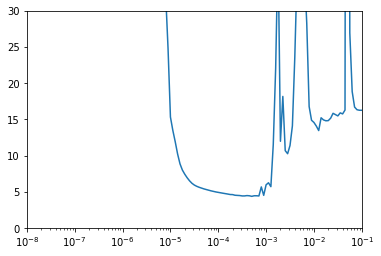

In [111]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 30])

#Model

In [112]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

In [ ]:
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [114]:
series[..., np.newaxis].shape

(1461, 1)

In [122]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

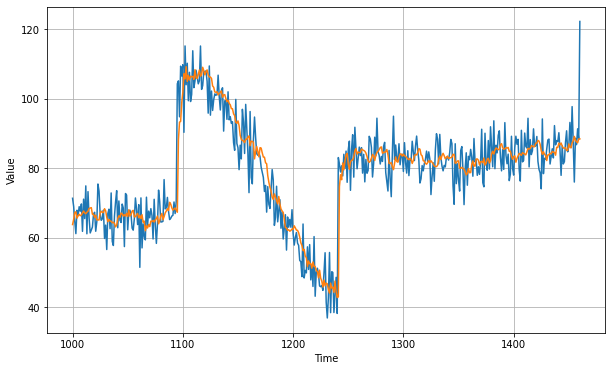

In [123]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [124]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.6565948

4.968691917889809

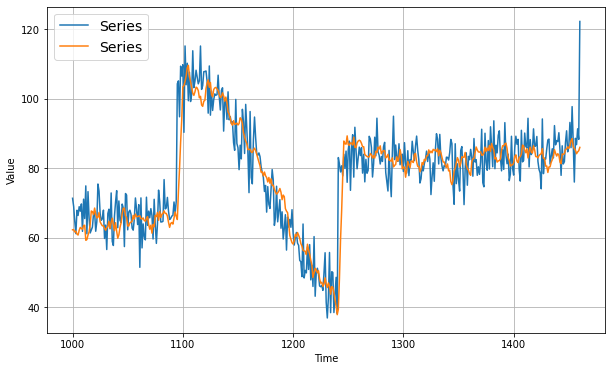

In [100]:
# adding back trend and seasonality iwth smoothing
smooth_past = moving_average_forecast(series, 5)[split_time-365-5:-365] 
moving_avg_plus_smooth_past = cnn_forecast + smooth_past

plt.figure(figsize=(10,6))
plot_series(time[split_time:], series[split_time:], label='Series')
plot_series(time[split_time:], moving_avg_plus_smooth_past, label='Series')

keras.metrics.mean_absolute_error(series[split_time:], moving_avg_plus_smooth_past).numpy()